<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #8: Agrupación de textos
`Fecha de entrega: Abril 29, 2021. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [2]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [4]:
# Cargar datos
path = '/content/reviews_vidjew_es.csv'
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


###  `[10 pts]` Punto 1: Hacer pre-procesamiento del texto

In [5]:
import nltk
nltk.download('stopwords')

stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = texto.split() # Tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp]
    texto = " ".join(texto)
    return texto
  
tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns= tfidf_vect.get_feature_names())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###  `[10 pts]` Punto 2: Método del codo para determinar $K$

In [8]:
ks = []
k_inertias = []

for k in range(1,10):
    print(k)
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_

    ks.append(k)
    k_inertias.append(k_inertia)

1
2
3
4
5
6
7
8
9


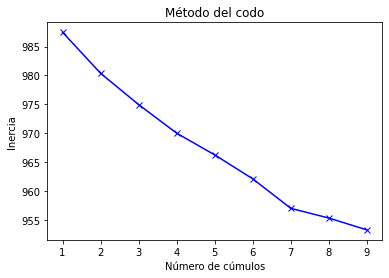

In [9]:
plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.plot(ks, k_inertias, 'bx-');

###  `[10 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [10]:
k = 7
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

###  `[15 pts]` Punto 4: Interpretación de los clusters

In [11]:
data['cluster'] = model.labels_
data

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,cluster
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry,3
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games,1
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games,0
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games,1
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games,1
...,...,...,...,...,...,...,...,...,...
995,es_0427672,product_es_0899883,reviewer_es_0474735,2,En la foto parece que la cadena sea más gruesa...,Cadena muy fina,es,jewelry,2
996,es_0059540,product_es_0702564,reviewer_es_0754753,3,"Bien por su precio, la cadena demasiado fina.",E,es,jewelry,1
997,es_0303349,product_es_0678671,reviewer_es_0172313,5,Muy bien!! Ahora tengo organizados los pendien...,Bonito,es,jewelry,1
998,es_0659961,product_es_0294943,reviewer_es_0554554,4,"Las tapas para los joystics no están nada mal,...",No está mal pero sólo he probado las fundas.,es,video_games,0


In [12]:
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)

centroids = model.cluster_centers_

terms = tfidf_vect.get_feature_names()
order_centroids = centroids.argsort()[:, ::-1]

for i in range(k):
    print(f"Cluster # {i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")
    print()
    
    print("TÉRMINOS MÁS REPRESENTATIVOS")
    for ind in order_centroids[i][:20]:
        print(terms[ind], end=" ")
    print()
    print()
    
    print(f"COMENTARIOS MÁS REPRESENTATIVOS")
    for vecino in data.iloc[nbrs.kneighbors([centroids[i]])[1][0]].review_body.values:
        print(f" *** {vecino}")
        print()
        
    print()
    print()

Cluster # 0
Tiene 503 registros (50.30% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
juego si llegado producto día solo foto mando mas jugar bonita llego amazon mal buen queda hijo caja plata pone 

COMENTARIOS MÁS REPRESENTATIVOS
 *** El juego en sí es increíble. A estas alturas de la generación poco más se puede decir salvo que es el simulador de conducción por excelencia, el mejor en su género en consolas. El pero viene por el envío de Amazon. El juego me lo envían sin precinto original, abierto, probablemente procedente de alguna devolución, cosa que no especifican en ningún momento. Además y para colmo, la caja vino con una de las pestañas rotas. Impresionante el mal gusto por parte de Amazon al enviar el producto de esta manera: Gracias a dios el disco está impoluto y el precio aún así mereció la pena, pero me tocará comprar algún juego de segunda mano barato para cambiar la caja.

 *** No ha llegado el collar . Las demás cosas que he comprado en Amazon han llegado, pero este prod

###  `[BONUS: 3 pts]` Visualización usando PCA

In [33]:
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
print(result.shape)
result.columns = ['X', 'Y']
result['cluster'] = data.cluster.values
result['texto'] = data.review_body.apply(lambda val: val[:140])

(1000, 2)


In [35]:
colorsIdx = {0: 'blue',
             1: 'yellow',
             2: 'green',
             3: 'red',
             4: 'orange',
             5: 'purple',
             6: 'brown'}

result['colores'] = result['cluster'].map(colorsIdx)

In [36]:
trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['colores'].values)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

# Comparación

### `[BONUS 20 pts (validos para cualquier tarea)]` 
### Hacer predicción para estas dos frases de los dos modelos (clasificación y $k$-means)

In [22]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]

In [37]:
nuevo_trans = tfidf_vect.transform(test)
[clusters[i] for i in model.predict(nuevo_trans)]

NameError: ignored

### `[5 pts]` Punto 5: Preguntas

- Según los resultados del $K$-Means, ¿cuál es la estructura de los datos?
- ¿Qué diferencia notó entre los resultados del taller pasado y este?
- ¿Alguna otra observación?

* Los resultados de 7 clusters, no permiten definir claramente las clases a las que pertenecen. Esto se observa también en la gráfica usando PCA, pues los colores están sobrepuestos y no hay separaciones claras. 

* El taller anterior tiene mejores resultados ya que el modelo se entrenó con etiquetas y por ende la predicción se restringía a las dos etiquetas que habían. Este por su parte crea las etiquetas y por ende es menos preciso al hacer la división.

* Para la data usada es más pertinente usar un modelo supervisado ya que cuenta con las etiquetas y de esta manera logramos obtener la clasificación en los parametros que tenemos y requerimos.